# Research Question: 
# How does the length of conversations with ChatGPT change based on the type of issue presented? 
## 2023_1012 Snapshot Analysis by Chaitanya Guntupalli (CG21BB)

## Working on commit_sharing.json file

### Extracting 'Prompts" and 'Answers' 

In [2]:
import pandas as pd
import json

data = pd.read_json("20231012_230826_commit_sharings.json")

prompts = []
answers = []

for source_item in data['Sources']:
    if isinstance(source_item, str):
        source_item = json.loads(source_item)
    
    for chatgpt_sharing_item in source_item.get('ChatgptSharing', []):
        for conversation in chatgpt_sharing_item.get('Conversations', []):
            prompts.append(conversation.get('Prompt', ''))
            answers.append(conversation.get('Answer', ''))
conversation_df = pd.DataFrame({'Prompt': prompts, 'Answer': answers})
print(conversation_df)


                                                 Prompt  \
0     このコードだと、スマートフォンでキーボードを表示したときにbuttonがキーボードの下に隠れ...   
1     このコードなんですが、Placeholder上でちゃんと改行するコードにできますか。\n\n...   
2     refactor this code.\n\n<!DOCTYPE html>\n<html>...   
3     server.js\n// Required libraries\nimport cors ...   
4     package.json\n{\n  "name": "mindfulai",\n  "ve...   
...                                                 ...   
1597   FAIL  ./game.test.js\n  ● Test suite failed t...   
1598   FAIL  ./game.test.js\n  ✕ check if startPlayi...   
1599                        we never changed index.html   
1600               why am i back to inlining javascript   
1601   FAIL  ./game.test.js\n  ● Test suite failed t...   

                                                 Answer  
0     ChatGPTキーボードが表示されたときにボタンをキーボードの上に移動させるには、CSSでキ...  
1     ChatGPTはい、改行を含むPlaceholder文字列を設定するコードを作成することがで...  
2     ChatGPTHere's a refactored version of your HTM...  
3     ChatGPTYou've shared multiple pieces of server...  
4

### General Key-Word Categorization which preprocesses the data for further categorization

In [3]:

def categorize_prompt(prompt):
    prompt = prompt.lower()
    if any(keyword in prompt for keyword in ["bug", "issue", "error"]):
        return "Bugs"
    elif any(keyword in prompt for keyword in ["feature", "enhancement", "add"]):
        return "Features"
    elif any(keyword in prompt for keyword in ["doc", "documentation", "manual"]):
        return "Documentation"
    else:
        return "Other"

conversation_df['Category'] = conversation_df['Prompt'].apply(categorize_prompt)
print(conversation_df.head())


                                              Prompt  \
0  このコードだと、スマートフォンでキーボードを表示したときにbuttonがキーボードの下に隠れ...   
1  このコードなんですが、Placeholder上でちゃんと改行するコードにできますか。\n\n...   
2  refactor this code.\n\n<!DOCTYPE html>\n<html>...   
3  server.js\n// Required libraries\nimport cors ...   
4  package.json\n{\n  "name": "mindfulai",\n  "ve...   

                                              Answer       Category  
0  ChatGPTキーボードが表示されたときにボタンをキーボードの上に移動させるには、CSSでキ...       Features  
1  ChatGPTはい、改行を含むPlaceholder文字列を設定するコードを作成することがで...  Documentation  
2  ChatGPTHere's a refactored version of your HTM...       Features  
3  ChatGPTYou've shared multiple pieces of server...           Bugs  
4  ChatGPTIt looks like you're having issues with...           Bugs  


### Importing spaCy NLP for Generating the key-words based on Topics detected by it in clusters

In [4]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer

nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and token.is_alpha]
    return " ".join(tokens)

conversation_df['Processed'] = conversation_df['Prompt'].apply(preprocess_text)

vectorizer = TfidfVectorizer(max_features=1000)  
X = vectorizer.fit_transform(conversation_df['Processed'])
from sklearn.decomposition import LatentDirichletAllocation

n_topics = 100  
lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
lda.fit(X)
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lda, vectorizer.get_feature_names_out(), 10)
topic_results = lda.transform(X)
conversation_df['Topic'] = topic_results.argmax(axis=1)
def map_topic_to_category(topic):
    mapping = {
        0: 'Category1',
        1: 'Category2',
    }
    return mapping.get(topic, 'Other')

conversation_df['Enhanced_Category'] = conversation_df['Topic'].apply(map_topic_to_category)


Topic 0:
tell read typeerror property undefined uncaught self promise reading early
Topic 1:
public algorithm exception section rsaprivatekey private key jwt return decodedjwt
Topic 2:
yes correctly entire style response work change key filename flattenedpath
Topic 3:
let keyword icon check category true sortname currentpage label score
Topic 4:
node module compile esm internal eslint eliminate test watch tsc
Topic 5:
use high recommend want style product store build code tool
Topic 6:
display localstorage value time provide expect define markdown code prompt
Topic 7:
prompt json templatevar saveto createprompt util file loadpromptdescriptor processprompt const
Topic 8:
log token https const server port express axio bitnami request
Topic 9:
sentence color refer fix contain javascript background true issue build
Topic 10:
test fail suite total nota jest run router dom time
Topic 11:
permission lib page cover get homepage config need true add
Topic 12:
dark extend theme light btn maxwidt

### Inital count of Categories

In [5]:
category_counts = conversation_df['Category'].value_counts()
print(category_counts)

Category
Other            731
Bugs             424
Features         373
Documentation     74
Name: count, dtype: int64


#### Number of Categories in "Other" more than any other, using NLP generated key-words to minimize the count

In [6]:
def categorize_prompt(prompt):
    prompt = prompt.lower()
    if any(keyword in prompt for keyword in ["bug", "issue", "error"]):
        return "Bugs"
    elif any(keyword in prompt for keyword in ["feature", "enhancement", "add"]):
        return "Features"
    elif any(keyword in prompt for keyword in ["doc", "documentation", "manual"]):
        return "Documentation"
    elif any(keyword in prompt for keyword in ["commit", "git", "version", "repository", "branch"]):
        return "Version Control Systems"
    elif any(keyword in prompt for keyword in ["html", "css", "javascript", "react", "web", "frontend", "design", "structure", "layout", "style", "markup"]):
        return "Web Development"
    elif any(keyword in prompt for keyword in ["api", "server", "backend", "express", "node", "https", "express", "axio", "network", "manage"]):
        return "Server and Backend Development"
    elif any(keyword in prompt for keyword in ["security", "authentication", "jwt", "rsa", "key", "private key", "encryption", "decodedjwt"]):
        return "Security"
    elif any(keyword in prompt for keyword in ["database", "json", "data", "storage", "sql"]):
        return "Data Handling and Databases"
    elif any(keyword in prompt for keyword in ["ui", "ux", "design", "interface", "user"]):
        return "UI/UX Design"
    elif any(keyword in prompt for keyword in ["style", "color", "background", "font", "css", "layout", "theme"]):
        return "Styling"
    elif any(keyword in prompt for keyword in ["vscode", "ide", "environment", "tool", "development", "eslint", "tsc", "compile", "module", "configuration"]):
        return "Development Tools and Environments"
    elif any(keyword in prompt for keyword in ["script", "automate", "bash", "shell", "command", "python", "streamline"]):
        return "Scripting and Automation"
    elif any(keyword in prompt for keyword in ["test", "debug", "error", "unittest", "software", "fail", "suite", "jest", "quality", "assurance", "unit test", "integration test"]):
        return "Software Testing"
    elif any(keyword in prompt for keyword in ["project", "manage", "collaborate", "team", "agile", "commit", "git", "version control", "repository"]):
        return "Project Management"
    elif any(keyword in prompt for keyword in ["documentation", "guide", "manual", "how-to", "tutorial", "markdown", "content", "write", "create", "edit", "publish"]):
        return "Documentation"
    elif any(keyword in prompt for keyword in ["performance, optimize, speed, efficiency, load"]):
        return "Performance Optimization"
    elif any(keyword in prompt for keyword in ["error", "debug", "exception", "fix", "troubleshoot", "typeerror", "uncaught", "promise", "problem", "issue"]):
        return "Error Handling"
    elif any(keyword in prompt for keyword in ["input", "interaction", "event", "user", "handle"]):
        return "User Input"
    elif any(keyword in prompt for keyword in ["file", "directory", "manage", "structure", "system"]):
        return "File Management"
    elif any(keyword in prompt for keyword in ["product", "store", "build", "market", "promote", "brand", "strategy", "sale", "recommendation", "audience"]):
        return "Product Development"
    elif any(keyword in prompt for keyword in ["localstorage", "value", "markdown", "json", "data", "storage", "database", "manage", "retrieve"]):
        return "Data Storage"
    elif any(keyword in prompt for keyword in ["template", "script", "create", "process", "load", "automate", "utility", "yaml", "json", "scripting"]):
        return "Template and Scripting"
    elif any(keyword in prompt for keyword in ["ide", "integration", "yaml", "vscode", "editor", "development", "tool", "environment"]):
        return "IDE Tools"
    elif any(keyword in prompt for keyword in ["ai", "machine learning", "model", "algorithm", "develop", "intelligent", "automate", "analyze"]):
        return "AI and ML"
    elif any(keyword in prompt for keyword in ["network", "communication", "protocol", "internet", "connect", "transmit", "data", "tcp", "udp"]):
        return "Networking and Communication"
    elif any(keyword in prompt for keyword in ["software", "application", "develop", "build", "create", "programming", "coding", "engineer"]):
        return "Software and Application Development"
    elif any(keyword in prompt for keyword in ["database", "sql", "management", "query", "data", "storage", "relational", "nosql", "organize"]):
        return "Database Management and SQL"
    elif any(keyword in prompt for keyword in ["visualization", "ui", "component", "display", "chart", "graph", "interface", "design", "frontend"]):
        return "Data Visualization and UI Components"
    elif any(keyword in prompt for keyword in [" cloud", "api", "service", "web", "remote", "online", "access", "interact", "integration"]):
        return "Cloud Services and Web APIs"
    elif any(keyword in prompt for keyword in [" performance", "optimize", "efficiency", "speed", "load", "streamline", "enhance", "improve"]):
        return "Performance Optimization"
    else:
        return "Other"
    
conversation_df['Category'] = conversation_df['Prompt'].apply(categorize_prompt)
print(conversation_df.head())


                                              Prompt  \
0  このコードだと、スマートフォンでキーボードを表示したときにbuttonがキーボードの下に隠れ...   
1  このコードなんですが、Placeholder上でちゃんと改行するコードにできますか。\n\n...   
2  refactor this code.\n\n<!DOCTYPE html>\n<html>...   
3  server.js\n// Required libraries\nimport cors ...   
4  package.json\n{\n  "name": "mindfulai",\n  "ve...   

                                              Answer       Category  \
0  ChatGPTキーボードが表示されたときにボタンをキーボードの上に移動させるには、CSSでキ...       Features   
1  ChatGPTはい、改行を含むPlaceholder文字列を設定するコードを作成することがで...  Documentation   
2  ChatGPTHere's a refactored version of your HTM...       Features   
3  ChatGPTYou've shared multiple pieces of server...           Bugs   
4  ChatGPTIt looks like you're having issues with...           Bugs   

                                           Processed  Topic Enhanced_Category  
0  scrollbar display important html textarea back...     96             Other  
1                                                         0         Category

In [24]:
category_counts = conversation_df['Category'].value_counts()
print(category_counts)

Category
Bugs                                    424
Features                                373
Other                                   240
Documentation                           104
Web Development                          74
Scripting and Automation                 56
Version Control Systems                  52
Development Tools and Environments       37
Security                                 37
Server and Backend Development           36
UI/UX Design                             36
AI and ML                                27
Data Handling and Databases              25
File Management                          17
Software Testing                         14
Styling                                  10
Error Handling                            6
Data Storage                              6
Template and Scripting                    5
User Input                                5
Project Management                        5
Cloud Services and Web APIs               4
Data Visualization and 

#### Count after adding the Generated Key-words made Categories

## Length of the Conversation calculation

In [7]:
import pandas as pd
import json

def categorize_prompt(prompt):
    prompt = prompt.lower()
    if any(keyword in prompt for keyword in ["bug", "issue", "error"]):
        return "Bugs"
    elif any(keyword in prompt for keyword in ["feature", "enhancement", "add"]):
        return "Features"
    elif any(keyword in prompt for keyword in ["doc", "documentation", "manual"]):
        return "Documentation"
    elif any(keyword in prompt for keyword in ["commit", "git", "version", "repository", "branch"]):
        return "Version Control Systems"
    elif any(keyword in prompt for keyword in ["html", "css", "javascript", "react", "web", "frontend", "design", "structure", "layout", "style", "markup"]):
        return "Web Development"
    elif any(keyword in prompt for keyword in ["api", "server", "backend", "express", "node", "https", "express", "axio", "network", "manage"]):
        return "Server and Backend Development"
    elif any(keyword in prompt for keyword in ["security", "authentication", "jwt", "rsa", "key", "private key", "encryption", "decodedjwt"]):
        return "Security"
    elif any(keyword in prompt for keyword in ["database", "json", "data", "storage", "sql"]):
        return "Data Handling and Databases"
    elif any(keyword in prompt for keyword in ["ui", "ux", "design", "interface", "user"]):
        return "UI/UX Design"
    elif any(keyword in prompt for keyword in ["style", "color", "background", "font", "css", "layout", "theme"]):
        return "Styling"
    elif any(keyword in prompt for keyword in ["vscode", "ide", "environment", "tool", "development", "eslint", "tsc", "compile", "module", "configuration"]):
        return "Development Tools and Environments"
    elif any(keyword in prompt for keyword in ["script", "automate", "bash", "shell", "command", "python", "streamline"]):
        return "Scripting and Automation"
    elif any(keyword in prompt for keyword in ["test", "debug", "error", "unittest", "software", "fail", "suite", "jest", "quality", "assurance", "unit test", "integration test"]):
        return "Software Testing"
    elif any(keyword in prompt for keyword in ["project", "manage", "collaborate", "team", "agile", "commit", "git", "version control", "repository"]):
        return "Project Management"
    elif any(keyword in prompt for keyword in ["documentation", "guide", "manual", "how-to", "tutorial", "markdown", "content", "write", "create", "edit", "publish"]):
        return "Documentation"
    elif any(keyword in prompt for keyword in ["performance, optimize, speed, efficiency, load"]):
        return "Performance Optimization"
    elif any(keyword in prompt for keyword in ["error", "debug", "exception", "fix", "troubleshoot", "typeerror", "uncaught", "promise", "problem", "issue"]):
        return "Error Handling"
    elif any(keyword in prompt for keyword in ["input", "interaction", "event", "user", "handle"]):
        return "User Input"
    elif any(keyword in prompt for keyword in ["file", "directory", "manage", "structure", "system"]):
        return "File Management"
    elif any(keyword in prompt for keyword in ["product", "store", "build", "market", "promote", "brand", "strategy", "sale", "recommendation", "audience"]):
        return "Product Development"
    elif any(keyword in prompt for keyword in ["localstorage", "value", "markdown", "json", "data", "storage", "database", "manage", "retrieve"]):
        return "Data Storage"
    elif any(keyword in prompt for keyword in ["template", "script", "create", "process", "load", "automate", "utility", "yaml", "json", "scripting"]):
        return "Template and Scripting"
    elif any(keyword in prompt for keyword in ["ide", "integration", "yaml", "vscode", "editor", "development", "tool", "environment"]):
        return "IDE Tools"
    elif any(keyword in prompt for keyword in ["ai", "machine learning", "model", "algorithm", "develop", "intelligent", "automate", "analyze"]):
        return "AI and ML"
    elif any(keyword in prompt for keyword in ["network", "communication", "protocol", "internet", "connect", "transmit", "data", "tcp", "udp"]):
        return "Networking and Communication"
    elif any(keyword in prompt for keyword in ["software", "application", "develop", "build", "create", "programming", "coding", "engineer"]):
        return "Software and Application Development"
    elif any(keyword in prompt for keyword in ["database", "sql", "management", "query", "data", "storage", "relational", "nosql", "organize"]):
        return "Database Management and SQL"
    elif any(keyword in prompt for keyword in ["visualization", "ui", "component", "display", "chart", "graph", "interface", "design", "frontend"]):
        return "Data Visualization and UI Components"
    elif any(keyword in prompt for keyword in [" cloud", "api", "service", "web", "remote", "online", "access", "interact", "integration"]):
        return "Cloud Services and Web APIs"
    elif any(keyword in prompt for keyword in [" performance", "optimize", "efficiency", "speed", "load", "streamline", "enhance", "improve"]):
        return "Performance Optimization"
    else:
        return "Other"

data = pd.read_json("20231012_230826_commit_sharings.json")

prompts = []
answers = []
conversation_lengths = []

for source_item in data['Sources']:
    if isinstance(source_item, str):
        source_item = json.loads(source_item)
    
    for chatgpt_sharing_item in source_item.get('ChatgptSharing', []):
        conversation_length = len(chatgpt_sharing_item.get('Conversations', []))
        
        for conversation in chatgpt_sharing_item.get('Conversations', []):
            prompts.append(conversation.get('Prompt', ''))
            answers.append(conversation.get('Answer', ''))
            conversation_lengths.append(conversation_length)

conversation_df = pd.DataFrame({
    'Prompt': prompts,
    'Answer': answers,
    'ConversationLength': conversation_lengths
})

conversation_df['Category'] = conversation_df['Prompt'].apply(categorize_prompt)
print(conversation_df.head())


                                              Prompt  \
0  このコードだと、スマートフォンでキーボードを表示したときにbuttonがキーボードの下に隠れ...   
1  このコードなんですが、Placeholder上でちゃんと改行するコードにできますか。\n\n...   
2  refactor this code.\n\n<!DOCTYPE html>\n<html>...   
3  server.js\n// Required libraries\nimport cors ...   
4  package.json\n{\n  "name": "mindfulai",\n  "ve...   

                                              Answer  ConversationLength  \
0  ChatGPTキーボードが表示されたときにボタンをキーボードの上に移動させるには、CSSでキ...                   1   
1  ChatGPTはい、改行を含むPlaceholder文字列を設定するコードを作成することがで...                   1   
2  ChatGPTHere's a refactored version of your HTM...                   1   
3  ChatGPTYou've shared multiple pieces of server...                   5   
4  ChatGPTIt looks like you're having issues with...                   5   

        Category  
0       Features  
1  Documentation  
2       Features  
3           Bugs  
4           Bugs  


## Data Visualization

### Using Horizantal graphs to interpret the data

In [11]:
!pip install pandas matplotlib seaborn

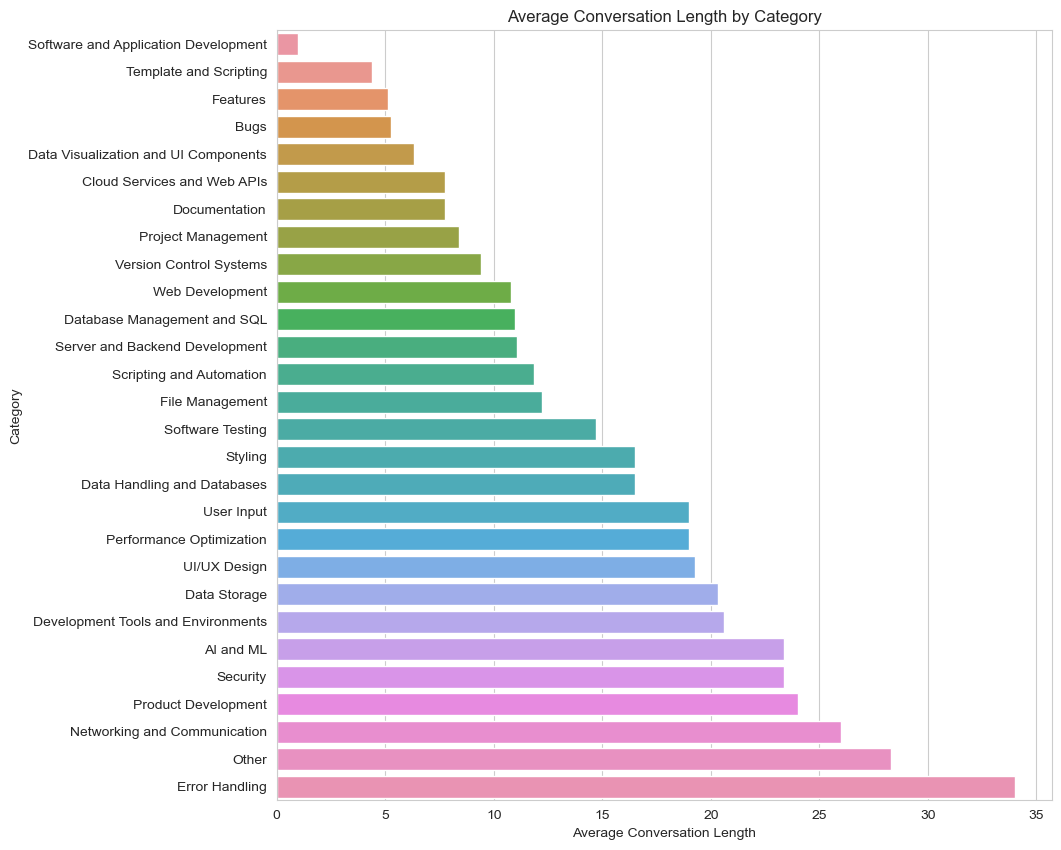

Category
Bugs                                    424
Features                                373
Other                                   240
Documentation                           104
Web Development                          74
Scripting and Automation                 56
Version Control Systems                  52
Development Tools and Environments       37
Security                                 37
Server and Backend Development           36
UI/UX Design                             36
AI and ML                                27
Data Handling and Databases              25
File Management                          17
Software Testing                         14
Styling                                  10
Error Handling                            6
Data Storage                              6
Template and Scripting                    5
User Input                                5
Project Management                        5
Cloud Services and Web APIs               4
Data Visualization and 

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

average_lengths = conversation_df.groupby('Category')['ConversationLength'].mean().sort_values()
sns.set_style("whitegrid")
plt.figure(figsize=(10, 10))
sns.barplot(x=average_lengths.values, y=average_lengths.index)

plt.title('Average Conversation Length by Category')
plt.xlabel('Average Conversation Length')
plt.ylabel('Category')

plt.show()
category_counts = conversation_df['Category'].value_counts()
print(category_counts)


### Findings
#### Bugs and Features: These categories might have a higher number of prompts because they are common topics in software development. However, the conversations in these categories might be relatively straightforward, leading to shorter average lengths.
#### Error Handling and Other: While these categories may have fewer prompts overall, the conversations within them might be more complex or require more back-and-forth interaction. Error handling, in particular, often involves troubleshooting, which can lead to longer conversations as different solutions are proposed and tested.
#### the reason for this discrepancy lies in the nature and complexity of the conversations within each category, not just the frequency of the prompts. Categories with more complex or problem-solving-oriented discussions, such as error handling, can have longer average conversation lengths even if they occur less frequently.

# -----------------------------------------------------------------------------------------

## Analysis on entire snapshot

In [9]:
import pandas as pd
import json

file_names = ['20231012_230826_commit_sharings.json', '20231012_232232_hn_sharings.json', '20231012_233628_pr_sharings.json', '20231012_234250_file_sharings.json', '20231012_235128_issue_sharings.json', '20231012_235320_discussion_sharings.json']

df_list = []

for file_name in file_names:
    with open(file_name, 'r') as file:
        data = json.load(file)
        prompts = []
        answers = []

        for source_item in data['Sources']:
            if isinstance(source_item, str):
                source_item = json.loads(source_item)

            for chatgpt_sharing_item in source_item.get('ChatgptSharing', []):
                for conversation in chatgpt_sharing_item.get('Conversations', []):
                    prompts.append(conversation.get('Prompt', ''))
                    answers.append(conversation.get('Answer', ''))

        temp_df = pd.DataFrame({'Prompt': prompts, 'Answer': answers})
        df_list.append(temp_df)

conversation_df = pd.concat(df_list, ignore_index=True)
print(conversation_df.head())


                                              Prompt  \
0  このコードだと、スマートフォンでキーボードを表示したときにbuttonがキーボードの下に隠れ...   
1  このコードなんですが、Placeholder上でちゃんと改行するコードにできますか。\n\n...   
2  refactor this code.\n\n<!DOCTYPE html>\n<html>...   
3  server.js\n// Required libraries\nimport cors ...   
4  package.json\n{\n  "name": "mindfulai",\n  "ve...   

                                              Answer  
0  ChatGPTキーボードが表示されたときにボタンをキーボードの上に移動させるには、CSSでキ...  
1  ChatGPTはい、改行を含むPlaceholder文字列を設定するコードを作成することがで...  
2  ChatGPTHere's a refactored version of your HTM...  
3  ChatGPTYou've shared multiple pieces of server...  
4  ChatGPTIt looks like you're having issues with...  


### Categorizing using the keywords generated by spaCy NLP

In [10]:
def categorize_prompt(prompt):
    prompt = prompt.lower()
    if any(keyword in prompt for keyword in ["bug", "issue", "error"]):
        return "Bugs"
    elif any(keyword in prompt for keyword in ["feature", "enhancement", "add"]):
        return "Features"
    elif any(keyword in prompt for keyword in ["doc", "documentation", "manual"]):
        return "Documentation"
    elif any(keyword in prompt for keyword in ["commit", "git", "version", "repository", "branch"]):
        return "Version Control Systems"
    elif any(keyword in prompt for keyword in ["html", "css", "javascript", "react", "web", "frontend", "design", "structure", "layout", "style", "markup"]):
        return "Web Development"
    elif any(keyword in prompt for keyword in ["api", "server", "backend", "express", "node", "https", "express", "axio", "network", "manage"]):
        return "Server and Backend Development"
    elif any(keyword in prompt for keyword in ["security", "authentication", "jwt", "rsa", "key", "private key", "encryption", "decodedjwt"]):
        return "Security"
    elif any(keyword in prompt for keyword in ["database", "json", "data", "storage", "sql"]):
        return "Data Handling and Databases"
    elif any(keyword in prompt for keyword in ["ui", "ux", "design", "interface", "user"]):
        return "UI/UX Design"
    elif any(keyword in prompt for keyword in ["style", "color", "background", "font", "css", "layout", "theme"]):
        return "Styling"
    elif any(keyword in prompt for keyword in ["vscode", "ide", "environment", "tool", "development", "eslint", "tsc", "compile", "module", "configuration"]):
        return "Development Tools and Environments"
    elif any(keyword in prompt for keyword in ["script", "automate", "bash", "shell", "command", "python", "streamline"]):
        return "Scripting and Automation"
    elif any(keyword in prompt for keyword in ["test", "debug", "error", "unittest", "software", "fail", "suite", "jest", "quality", "assurance", "unit test", "integration test"]):
        return "Software Testing"
    elif any(keyword in prompt for keyword in ["project", "manage", "collaborate", "team", "agile", "commit", "git", "version control", "repository"]):
        return "Project Management"
    elif any(keyword in prompt for keyword in ["documentation", "guide", "manual", "how-to", "tutorial", "markdown", "content", "write", "create", "edit", "publish"]):
        return "Documentation"
    elif any(keyword in prompt for keyword in ["performance, optimize, speed, efficiency, load"]):
        return "Performance Optimization"
    elif any(keyword in prompt for keyword in ["error", "debug", "exception", "fix", "troubleshoot", "typeerror", "uncaught", "promise", "problem", "issue"]):
        return "Error Handling"
    elif any(keyword in prompt for keyword in ["input", "interaction", "event", "user", "handle"]):
        return "User Input"
    elif any(keyword in prompt for keyword in ["file", "directory", "manage", "structure", "system"]):
        return "File Management"
    elif any(keyword in prompt for keyword in ["product", "store", "build", "market", "promote", "brand", "strategy", "sale", "recommendation", "audience"]):
        return "Product Development"
    elif any(keyword in prompt for keyword in ["localstorage", "value", "markdown", "json", "data", "storage", "database", "manage", "retrieve"]):
        return "Data Storage"
    elif any(keyword in prompt for keyword in ["template", "script", "create", "process", "load", "automate", "utility", "yaml", "json", "scripting"]):
        return "Template and Scripting"
    elif any(keyword in prompt for keyword in ["ide", "integration", "yaml", "vscode", "editor", "development", "tool", "environment"]):
        return "IDE Tools"
    elif any(keyword in prompt for keyword in ["ai", "machine learning", "model", "algorithm", "develop", "intelligent", "automate", "analyze"]):
        return "AI and ML"
    elif any(keyword in prompt for keyword in ["network", "communication", "protocol", "internet", "connect", "transmit", "data", "tcp", "udp"]):
        return "Networking and Communication"
    elif any(keyword in prompt for keyword in ["software", "application", "develop", "build", "create", "programming", "coding", "engineer"]):
        return "Software and Application Development"
    elif any(keyword in prompt for keyword in ["database", "sql", "management", "query", "data", "storage", "relational", "nosql", "organize"]):
        return "Database Management and SQL"
    elif any(keyword in prompt for keyword in ["visualization", "ui", "component", "display", "chart", "graph", "interface", "design", "frontend"]):
        return "Data Visualization and UI Components"
    elif any(keyword in prompt for keyword in [" cloud", "api", "service", "web", "remote", "online", "access", "interact", "integration"]):
        return "Cloud Services and Web APIs"
    elif any(keyword in prompt for keyword in [" performance", "optimize", "efficiency", "speed", "load", "streamline", "enhance", "improve"]):
        return "Performance Optimization"
    else:
        return "Other"
conversation_df['Category'] = conversation_df['Prompt'].apply(categorize_prompt)

print(conversation_df.head())


                                              Prompt  \
0  このコードだと、スマートフォンでキーボードを表示したときにbuttonがキーボードの下に隠れ...   
1  このコードなんですが、Placeholder上でちゃんと改行するコードにできますか。\n\n...   
2  refactor this code.\n\n<!DOCTYPE html>\n<html>...   
3  server.js\n// Required libraries\nimport cors ...   
4  package.json\n{\n  "name": "mindfulai",\n  "ve...   

                                              Answer       Category  
0  ChatGPTキーボードが表示されたときにボタンをキーボードの上に移動させるには、CSSでキ...       Features  
1  ChatGPTはい、改行を含むPlaceholder文字列を設定するコードを作成することがで...  Documentation  
2  ChatGPTHere's a refactored version of your HTM...       Features  
3  ChatGPTYou've shared multiple pieces of server...           Bugs  
4  ChatGPTIt looks like you're having issues with...           Bugs  


In [29]:
category_counts = conversation_df['Category'].value_counts()
print(category_counts)

Category
Other                                   10481
Bugs                                     2863
Features                                 2256
Documentation                            1294
Web Development                          1273
UI/UX Design                             1185
AI and ML                                1169
Development Tools and Environments       1018
Server and Backend Development            880
Version Control Systems                   782
Data Handling and Databases               772
Scripting and Automation                  604
Software Testing                          406
Security                                  358
Error Handling                            333
File Management                           285
Styling                                   188
Data Storage                              153
User Input                                137
Product Development                       132
Project Management                        126
Template and Scripting   

### Length of Conversation calculation for all .Json files

In [11]:
import pandas as pd
import json

def categorize_prompt(prompt):
    prompt = prompt.lower()
    if any(keyword in prompt for keyword in ["bug", "issue", "error"]):
        return "Bugs"
    elif any(keyword in prompt for keyword in ["feature", "enhancement", "add"]):
        return "Features"
    elif any(keyword in prompt for keyword in ["doc", "documentation", "manual"]):
        return "Documentation"
    elif any(keyword in prompt for keyword in ["commit", "git", "version", "repository", "branch"]):
        return "Version Control Systems"
    elif any(keyword in prompt for keyword in ["html", "css", "javascript", "react", "web", "frontend", "design", "structure", "layout", "style", "markup"]):
        return "Web Development"
    elif any(keyword in prompt for keyword in ["api", "server", "backend", "express", "node", "https", "express", "axio", "network", "manage"]):
        return "Server and Backend Development"
    elif any(keyword in prompt for keyword in ["security", "authentication", "jwt", "rsa", "key", "private key", "encryption", "decodedjwt"]):
        return "Security"
    elif any(keyword in prompt for keyword in ["database", "json", "data", "storage", "sql"]):
        return "Data Handling and Databases"
    elif any(keyword in prompt for keyword in ["ui", "ux", "design", "interface", "user"]):
        return "UI/UX Design"
    elif any(keyword in prompt for keyword in ["style", "color", "background", "font", "css", "layout", "theme"]):
        return "Styling"
    elif any(keyword in prompt for keyword in ["vscode", "ide", "environment", "tool", "development", "eslint", "tsc", "compile", "module", "configuration"]):
        return "Development Tools and Environments"
    elif any(keyword in prompt for keyword in ["script", "automate", "bash", "shell", "command", "python", "streamline"]):
        return "Scripting and Automation"
    elif any(keyword in prompt for keyword in ["test", "debug", "error", "unittest", "software", "fail", "suite", "jest", "quality", "assurance", "unit test", "integration test"]):
        return "Software Testing"
    elif any(keyword in prompt for keyword in ["project", "manage", "collaborate", "team", "agile", "commit", "git", "version control", "repository"]):
        return "Project Management"
    elif any(keyword in prompt for keyword in ["documentation", "guide", "manual", "how-to", "tutorial", "markdown", "content", "write", "create", "edit", "publish"]):
        return "Documentation"
    elif any(keyword in prompt for keyword in ["performance, optimize, speed, efficiency, load"]):
        return "Performance Optimization"
    elif any(keyword in prompt for keyword in ["error", "debug", "exception", "fix", "troubleshoot", "typeerror", "uncaught", "promise", "problem", "issue"]):
        return "Error Handling"
    elif any(keyword in prompt for keyword in ["input", "interaction", "event", "user", "handle"]):
        return "User Input"
    elif any(keyword in prompt for keyword in ["file", "directory", "manage", "structure", "system"]):
        return "File Management"
    elif any(keyword in prompt for keyword in ["product", "store", "build", "market", "promote", "brand", "strategy", "sale", "recommendation", "audience"]):
        return "Product Development"
    elif any(keyword in prompt for keyword in ["localstorage", "value", "markdown", "json", "data", "storage", "database", "manage", "retrieve"]):
        return "Data Storage"
    elif any(keyword in prompt for keyword in ["template", "script", "create", "process", "load", "automate", "utility", "yaml", "json", "scripting"]):
        return "Template and Scripting"
    elif any(keyword in prompt for keyword in ["ide", "integration", "yaml", "vscode", "editor", "development", "tool", "environment"]):
        return "IDE Tools"
    elif any(keyword in prompt for keyword in ["ai", "machine learning", "model", "algorithm", "develop", "intelligent", "automate", "analyze"]):
        return "AI and ML"
    elif any(keyword in prompt for keyword in ["network", "communication", "protocol", "internet", "connect", "transmit", "data", "tcp", "udp"]):
        return "Networking and Communication"
    elif any(keyword in prompt for keyword in ["software", "application", "develop", "build", "create", "programming", "coding", "engineer"]):
        return "Software and Application Development"
    elif any(keyword in prompt for keyword in ["database", "sql", "management", "query", "data", "storage", "relational", "nosql", "organize"]):
        return "Database Management and SQL"
    elif any(keyword in prompt for keyword in ["visualization", "ui", "component", "display", "chart", "graph", "interface", "design", "frontend"]):
        return "Data Visualization and UI Components"
    elif any(keyword in prompt for keyword in [" cloud", "api", "service", "web", "remote", "online", "access", "interact", "integration"]):
        return "Cloud Services and Web APIs"
    elif any(keyword in prompt for keyword in [" performance", "optimize", "efficiency", "speed", "load", "streamline", "enhance", "improve"]):
        return "Performance Optimization"
    else:
        return "Other"
json_files = [
    "20231012_230826_commit_sharings.json",
    "20231012_232232_hn_sharings.json",
    "20231012_233628_pr_sharings.json",
    "20231012_234250_file_sharings.json",
    "20231012_235128_issue_sharings.json",
    "20231012_235320_discussion_sharings.json"
]

prompts = []
answers = []
conversation_lengths = []

for json_file in json_files:
    data = pd.read_json(json_file)
    for source_item in data['Sources']:
        if isinstance(source_item, str):
            source_item = json.loads(source_item)
        
        for chatgpt_sharing_item in source_item.get('ChatgptSharing', []):
            conversation_length = len(chatgpt_sharing_item.get('Conversations', []))
            
            for conversation in chatgpt_sharing_item.get('Conversations', []):
                prompts.append(conversation.get('Prompt', ''))
                answers.append(conversation.get('Answer', ''))
                conversation_lengths.append(conversation_length)

conversation_df = pd.DataFrame({
    'Prompt': prompts,
    'Answer': answers,
    'ConversationLength': conversation_lengths
})

conversation_df['Category'] = conversation_df['Prompt'].apply(categorize_prompt)

print(conversation_df.head())


                                              Prompt  \
0  このコードだと、スマートフォンでキーボードを表示したときにbuttonがキーボードの下に隠れ...   
1  このコードなんですが、Placeholder上でちゃんと改行するコードにできますか。\n\n...   
2  refactor this code.\n\n<!DOCTYPE html>\n<html>...   
3  server.js\n// Required libraries\nimport cors ...   
4  package.json\n{\n  "name": "mindfulai",\n  "ve...   

                                              Answer  ConversationLength  \
0  ChatGPTキーボードが表示されたときにボタンをキーボードの上に移動させるには、CSSでキ...                   1   
1  ChatGPTはい、改行を含むPlaceholder文字列を設定するコードを作成することがで...                   1   
2  ChatGPTHere's a refactored version of your HTM...                   1   
3  ChatGPTYou've shared multiple pieces of server...                   5   
4  ChatGPTIt looks like you're having issues with...                   5   

        Category  
0       Features  
1  Documentation  
2       Features  
3           Bugs  
4           Bugs  


### Interpreting the data in a Horizontal Bar graph with crucial findings

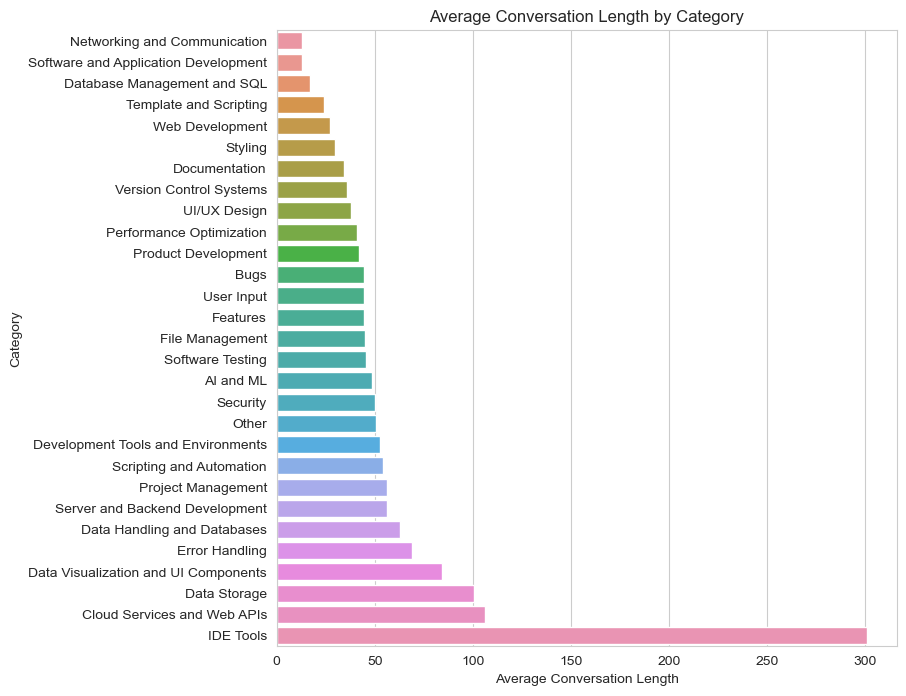

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

average_lengths = conversation_df.groupby('Category')['ConversationLength'].mean().sort_values()
sns.set_style("whitegrid")
plt.figure(figsize=(8, 8))
sns.barplot(x=average_lengths.values, y=average_lengths.index)

plt.title('Average Conversation Length by Category')
plt.xlabel('Average Conversation Length')
plt.ylabel('Category')

plt.show()
